In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from google.colab import drive
import warnings
warnings.filterwarnings(action='ignore')

In [59]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [3]:
# 구글 드라이브 연결
drive.mount("/content/gdrive/")

Mounted at /content/gdrive/


## 1) 데이터 준비

In [12]:
df = pd.read_csv('/content/gdrive/MyDrive/coaching_study/study/data/diabetes_feature.csv')

df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,Pregnancies_high,Insulin_nan,Insulin_log
0,6,0.743719,0.590164,0.353535,0,33.6,0.234415,50,1,False,169.5,5.138735
1,1,0.427136,0.540984,0.292929,0,26.6,0.116567,31,0,False,102.5,4.639572
2,8,0.919598,0.524590,0.000000,0,23.3,0.253629,32,1,True,169.5,5.138735
3,1,0.447236,0.540984,0.232323,94,28.1,0.038002,21,0,False,94.0,4.553877
4,0,0.688442,0.327869,0.353535,168,43.1,0.943638,33,1,False,168.0,5.129899


In [13]:
feature_names = ['Glucose', 'BloodPressure', 'SkinThickness', 'BMI',
                 'DiabetesPedigreeFunction', 'Age', 'Pregnancies_high', 'Insulin_log']

X = df[feature_names]
y = df['Outcome']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y,
                                                    test_size=0.2, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((598, 8), (150, 8), (598,), (150,))

## 2) 모델 학습

### (1) DecisionTree 최적의 파라미터 찾기



> max_depth: 3 -> Accuracy: 89.33%



In [14]:
model = DecisionTreeClassifier(random_state=42).fit(X_train, y_train)

pred = model.predict(X_test)

acc = accuracy_score(pred, y_test) * 100
print(f'Accuracy: {acc}%')

Accuracy: 86.66666666666667%


In [16]:
for max_depth in range(3, 13):
  model = DecisionTreeClassifier(max_depth=max_depth, random_state=42).fit(X_train, y_train)

  pred = model.predict(X_test)
  acc = accuracy_score(pred, y_test) * 100

  print(f'max_depth: {max_depth} -> Accuracy: {round(acc, 2)}%')

max_depth: 3 -> Accuracy: 89.33%
max_depth: 4 -> Accuracy: 89.33%
max_depth: 5 -> Accuracy: 84.0%
max_depth: 6 -> Accuracy: 87.33%
max_depth: 7 -> Accuracy: 84.67%
max_depth: 8 -> Accuracy: 88.0%
max_depth: 9 -> Accuracy: 86.67%
max_depth: 10 -> Accuracy: 86.67%
max_depth: 11 -> Accuracy: 86.67%
max_depth: 12 -> Accuracy: 86.67%


#### GridSearchCV 이용

시도해 볼 하이퍼파라미터들을 지정하면 모든 조합에 대해 교차검증 후 제일 좋은 성능을 내는 조합을 찾음



> DecisionTreeClassifier(max_depth=6, max_features=0.7, random_state=42) \
=> Accuracy: 87.33%




In [26]:
model = DecisionTreeClassifier(random_state=42)
param_grid = {'max_depth':range(2, 13),
              'max_features':[0.2, 0.3, 0.5, 0.7, 0.9, 1.0]}

grid_model = GridSearchCV(model, param_grid=param_grid, cv=5, verbose=1)
grid_model.fit(X_train, y_train)

Fitting 5 folds for each of 66 candidates, totalling 330 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'max_depth': range(2, 13),
                         'max_features': [0.2, 0.3, 0.5, 0.7, 0.9, 1.0]},
             verbose=1)

In [27]:
print(grid_model.best_params_)
print(grid_model.best_score_)
print(grid_model.best_estimator_)

{'max_depth': 6, 'max_features': 0.7}
0.8694957983193277
DecisionTreeClassifier(max_depth=6, max_features=0.7, random_state=42)


In [28]:
pd.DataFrame(grid_model.cv_results_).sort_values('rank_test_score').head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
27,0.003479,0.000080,0.001943,0.000043,6,0.7,"{'max_depth': 6, 'max_features': 0.7}",0.850000,0.941667,0.858333,0.857143,0.840336,0.869496,0.036650,1
9,0.010095,0.006120,0.004459,0.002228,3,0.7,"{'max_depth': 3, 'max_features': 0.7}",0.866667,0.908333,0.858333,0.848739,0.857143,0.867843,0.021027,2
8,0.005425,0.000148,0.004722,0.002588,3,0.5,"{'max_depth': 3, 'max_features': 0.5}",0.833333,0.908333,0.858333,0.873950,0.857143,0.866218,0.024736,3


In [29]:
pred = grid_model.predict(X_test)

acc = accuracy_score(pred, y_test) * 100
print(f'Accuracy: {round(acc, 2)}%')

Accuracy: 87.33%


#### RandomizedSearchCV 이용

 GridSearch와 동일한 방식으로 사용하지만, 모든 조합을 다 시도하지 않고 각 반복마다 임의의 값을 대입해 지정한 횟수만큼만 평가 \
 -> 데이터가 많고 파라미터 튜닝이 많이 필요할 때 이용하면 좋음



> DecisionTreeClassifier(max_depth=3, max_features=0.7, random_state=42) \
=> Accuracy: 89.33%




In [21]:
max_depth = np.random.randint(1, 21, 20)
max_features = np.random.uniform(0.1, 1.0, 100)

In [22]:
model = DecisionTreeClassifier(random_state=42)
param_grid = {'max_depth':range(2, 13),
              'max_features':[0.1, 0.2, 0.3, 0.5, 0.7, 0.9, 1.0]}
# param_grid = {'max_depth':max_depth,
#               'max_features':max_features}

random_model = RandomizedSearchCV(model, param_distributions=param_grid,
                                  n_iter=60, scoring='accuracy',
                                  cv=5, random_state=42)
random_model.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42),
                   n_iter=60,
                   param_distributions={'max_depth': range(2, 13),
                                        'max_features': [0.1, 0.2, 0.3, 0.5,
                                                         0.7, 0.9, 1.0]},
                   random_state=42, scoring='accuracy')

In [23]:
print(random_model.best_params_)
print(random_model.best_score_)
print(random_model.best_estimator_)

{'max_features': 0.7, 'max_depth': 3}
0.8678431372549019
DecisionTreeClassifier(max_depth=3, max_features=0.7, random_state=42)


In [24]:
pd.DataFrame(random_model.cv_results_).sort_values('rank_test_score').head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
59,0.004007,0.000455,0.002372,0.000327,0.7,3,"{'max_features': 0.7, 'max_depth': 3}",0.866667,0.908333,0.858333,0.848739,0.857143,0.867843,0.021027,1
2,0.004673,0.000183,0.002914,0.000084,0.5,3,"{'max_features': 0.5, 'max_depth': 3}",0.833333,0.908333,0.858333,0.873950,0.857143,0.866218,0.024736,2
13,0.006582,0.001814,0.003492,0.000450,0.9,3,"{'max_features': 0.9, 'max_depth': 3}",0.866667,0.908333,0.850000,0.848739,0.857143,0.866176,0.022022,3


In [25]:
pred = random_model.predict(X_test)

acc = accuracy_score(pred, y_test) * 100
print(f'Accuracy: {round(acc, 2)}%')

Accuracy: 89.33%


### (2) RandomForest



> max_depth: 4 + estimator: 100 -> Accuracy: 92.67%



In [46]:
model = RandomForestClassifier(random_state=42).fit(X_train, y_train)

pred = model.predict(X_test)

acc = accuracy_score(pred, y_test) * 100
print(f'Accuracy: {round(acc, 2)}%')

Accuracy: 92.0%


In [50]:
for estimator in range(10, 110, 10):
  model = RandomForestClassifier(n_estimators=estimator, random_state=42).fit(X_train, y_train)

  pred = model.predict(X_test)
  acc = accuracy_score(pred, y_test) * 100

  print(f'estimator: {estimator} -> Accuracy: {round(acc, 2)}%')

estimator: 10 -> Accuracy: 89.33%
estimator: 20 -> Accuracy: 90.0%
estimator: 30 -> Accuracy: 89.33%
estimator: 40 -> Accuracy: 90.67%
estimator: 50 -> Accuracy: 91.33%
estimator: 60 -> Accuracy: 90.67%
estimator: 70 -> Accuracy: 91.33%
estimator: 80 -> Accuracy: 91.33%
estimator: 90 -> Accuracy: 92.0%
estimator: 100 -> Accuracy: 92.0%


In [53]:
model = RandomForestClassifier(max_depth=4, n_estimators=100, random_state=42).fit(X_train, y_train)

pred = model.predict(X_test)

acc = accuracy_score(pred, y_test) * 100
print(f'Accuracy: {round(acc, 2)}%')

Accuracy: 92.67%


<Axes: >

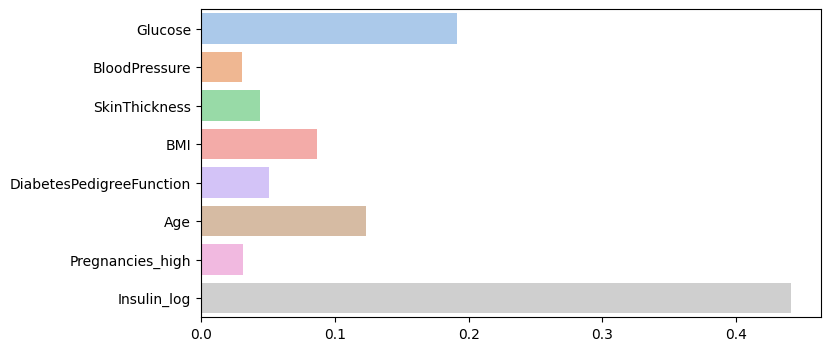

In [54]:
plt.figure(figsize=(8, 4))
sns.barplot(x=model.feature_importances_, y=feature_names, palette=sns.color_palette('pastel'))

### (3) Boosting



> estimator: 20 -> Accuracy: 93.33%



In [56]:
model = GradientBoostingClassifier(random_state=42).fit(X_train, y_train)

pred = model.predict(X_test)

acc = accuracy_score(pred, y_test) * 100
print(f'Accuracy: {round(acc, 2)}%')

Accuracy: 90.0%


In [58]:
for max_depth in range(3, 10):
  model = GradientBoostingClassifier(max_depth=max_depth, random_state=42).fit(X_train, y_train)

  pred = model.predict(X_test)
  acc = accuracy_score(pred, y_test) * 100

  print(f'max_depth: {max_depth} -> Accuracy: {round(acc, 2)}%')

max_depth: 3 -> Accuracy: 90.0%
max_depth: 4 -> Accuracy: 90.67%
max_depth: 5 -> Accuracy: 90.0%
max_depth: 6 -> Accuracy: 90.67%
max_depth: 7 -> Accuracy: 88.67%
max_depth: 8 -> Accuracy: 85.33%
max_depth: 9 -> Accuracy: 89.33%


In [67]:
for estimator in range(10, 60, 10):
  model = GradientBoostingClassifier(n_estimators=estimator, random_state=42).fit(X_train, y_train)

  pred = model.predict(X_test)
  acc = accuracy_score(pred, y_test) * 100

  print(f'estimator: {estimator} -> Accuracy: {round(acc, 2)}%')

estimator: 10 -> Accuracy: 90.67%
estimator: 20 -> Accuracy: 93.33%
estimator: 30 -> Accuracy: 92.0%
estimator: 40 -> Accuracy: 90.0%
estimator: 50 -> Accuracy: 91.33%


In [72]:
model = GradientBoostingClassifier(max_depth=3, n_estimators=20, random_state=42).fit(X_train, y_train)

pred = model.predict(X_test)

acc = accuracy_score(pred, y_test) * 100
print(f'Accuracy: {round(acc, 2)}%')

Accuracy: 93.33%


### (4) RandomizedSearchCV로 여러 알고리즘 비교



> DecisionTreeClassifier(random_state=42) <br>
'max_features': 0.7710070198357875, 'max_depth': 3 \
-> best_score: 0.864566 | score: 0.893333 <br><br>
RandomForestClassifier(random_state=42) <br>
'max_features': 0.7546539767582854, 'max_depth': 3 \
-> best_score: 0.881190 | score: 0.920000 <br><br>
GradientBoostingClassifier(random_state=42)<br>
'max_features': 0.45609313660378314, 'max_depth': 10 \
-> best_score: 0.879594 | score: 0.920000



In [94]:
estimators = [DecisionTreeClassifier(random_state=42),
              RandomForestClassifier(random_state=42),
              GradientBoostingClassifier(random_state=42)]

max_depth = np.random.randint(3, 20, 10)
max_features = np.random.uniform(0.2, 1.0, 10)

param_distributions = {'max_depth':max_depth, 'max_features':max_features}

results = []

for estimator in estimators:
  result = []

  model_clf = RandomizedSearchCV(estimator, param_distributions=param_distributions,
                                 n_iter=100, scoring='accuracy', cv=5, verbose=1)
  model_clf.fit(X_train, y_train)

  result.append(estimator.__class__.__name__)
  result.append(model_clf.best_params_)
  result.append(model_clf.best_score_)
  result.append(model_clf.score(X_test, y_test))
  result.append(model_clf.cv_results_)
  results.append(result)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits


In [93]:
n_iter_10 = pd.DataFrame(results,
                         columns=['estimator', 'best_params', 'best_score', 'score', 'cv_results'])
n_iter_10

,estimator,best_params,best_score,score,cv_results
0,DecisionTreeClassifier,"{'max_features': 0.7710070198357875, 'max_dept...",0.864566,0.893333,"{'mean_fit_time': [0.0072895526885986325, 0.00..."
1,RandomForestClassifier,"{'max_features': 0.7546539767582854, 'max_dept...",0.881190,0.920000,"{'mean_fit_time': [0.3164838314056396, 0.21739..."
2,GradientBoostingClassifier,"{'max_features': 0.45609313660378314, 'max_dep...",0.879594,0.920000,"{'mean_fit_time': [0.1797177314758301, 0.84310..."


In [129]:
pd.DataFrame(n_iter_10.loc[1, 'cv_results']).sort_values(by='rank_test_score').head(5)

# max_features의 범위를 0.3~0.8 / max_depth의 범위는 3~15 정도로 두고 학습시키면 좋을 듯 하다

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
4,0.194541,0.007826,0.009167,0.000213,0.754654,3,"{'max_features': 0.7546539767582854, 'max_dept...",0.891667,0.941667,0.858333,0.873950,0.840336,0.881190,0.034673,1
2,0.190663,0.005398,0.009702,0.000371,0.323141,13,"{'max_features': 0.32314101371130666, 'max_dep...",0.850000,0.908333,0.875000,0.882353,0.873950,0.877927,0.018700,2
6,0.208501,0.010031,0.009708,0.000367,0.50311,11,"{'max_features': 0.5031101838988716, 'max_dept...",0.866667,0.933333,0.841667,0.890756,0.857143,0.877913,0.031963,3
5,0.226174,0.005213,0.010549,0.002211,0.754654,15,"{'max_features': 0.7546539767582854, 'max_dept...",0.850000,0.941667,0.858333,0.890756,0.848739,0.877899,0.035336,4
7,0.229865,0.007910,0.009596,0.000438,0.773826,14,"{'max_features': 0.7738260567027797, 'max_dept...",0.850000,0.941667,0.858333,0.890756,0.848739,0.877899,0.035336,4


In [96]:
n_iter_100 = pd.DataFrame(results,
                          columns=['estimator', 'best_params', 'best_score', 'score', 'cv_results'])
n_iter_100

,estimator,best_params,best_score,score,cv_results
0,DecisionTreeClassifier,"{'max_features': 0.8033598957246106, 'max_dept...",0.857885,0.853333,"{'mean_fit_time': [0.003931283950805664, 0.003..."
1,RandomForestClassifier,"{'max_features': 0.22544507634809208, 'max_dep...",0.882927,0.906667,"{'mean_fit_time': [0.2897519111633301, 0.30761..."
2,GradientBoostingClassifier,"{'max_features': 0.427633562781367, 'max_depth...",0.886275,0.900000,"{'mean_fit_time': [0.35361390113830565, 0.2983..."


In [128]:
pd.DataFrame(n_iter_100.loc[1, 'cv_results']).sort_values(by='rank_test_score').head(5)

# max_features의 범위를 0.2~0.8 / max_depth의 범위는 5~10 정도로 두고 학습시키면 좋을 듯 하다

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
25,0.180978,0.004303,0.010102,0.000285,0.225445,9,"{'max_features': 0.22544507634809208, 'max_dep...",0.841667,0.941667,0.875000,0.882353,0.873950,0.882927,0.032547,1
45,0.176643,0.002798,0.010073,0.001057,0.225445,9,"{'max_features': 0.22544507634809208, 'max_dep...",0.841667,0.941667,0.875000,0.882353,0.873950,0.882927,0.032547,1
13,0.266511,0.057238,0.011164,0.002063,0.738229,8,"{'max_features': 0.7382292350283961, 'max_dept...",0.875000,0.916667,0.866667,0.882353,0.865546,0.881246,0.018729,3
31,0.290010,0.005734,0.014659,0.001839,0.427634,5,"{'max_features': 0.427633562781367, 'max_depth...",0.883333,0.950000,0.850000,0.857143,0.865546,0.881204,0.036153,4
49,0.187818,0.003958,0.009819,0.000116,0.305133,9,"{'max_features': 0.3051329676058857, 'max_dept...",0.866667,0.933333,0.841667,0.882353,0.873950,0.879594,0.030110,5


### (5) xgboost



> max_depth=3 -> Accuracy: 92.0%



In [134]:
import xgboost
from xgboost import XGBClassifier
from xgboost import plot_importance, plot_tree

In [122]:
model = XGBClassifier(random_state=42, learning_rate=0.1, max_depth=3).fit(X_train, y_train)

pred = model.predict(X_test)

acc = accuracy_score(pred, y_test) * 100
print(f'Accuracy: {round(acc, 2)}%')

Accuracy: 91.33%


In [131]:
for max_depth in range(3, 11):
  model = XGBClassifier(max_depth=max_depth, random_state=42).fit(X_train, y_train)

  pred = model.predict(X_test)
  acc = accuracy_score(pred, y_test) * 100

  print(f'max_depth: {max_depth} -> Accuracy: {round(acc, 2)}%')

max_depth: 3 -> Accuracy: 92.0%
max_depth: 4 -> Accuracy: 90.67%
max_depth: 5 -> Accuracy: 92.0%
max_depth: 6 -> Accuracy: 91.33%
max_depth: 7 -> Accuracy: 91.33%
max_depth: 8 -> Accuracy: 91.33%
max_depth: 9 -> Accuracy: 88.67%
max_depth: 10 -> Accuracy: 90.67%


In [132]:
model = XGBClassifier(random_state=42, max_depth=3).fit(X_train, y_train)

pred = model.predict(X_test)

acc = accuracy_score(pred, y_test) * 100
print(f'Accuracy: {round(acc, 2)}%')

Accuracy: 92.0%


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

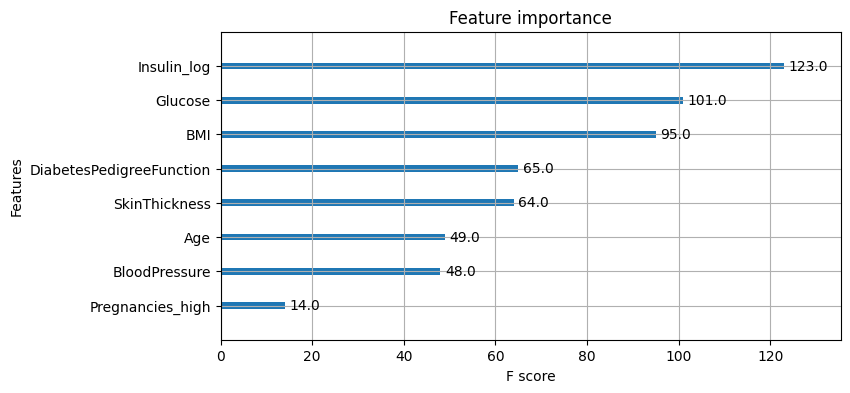

In [135]:
_, ax = plt.subplots(figsize=(8, 4))
plot_importance(model, ax=ax)

## 마무리

정확도만을 고려했을 때, \
GradientBoostingClassifier(max_depth=3, n_estimators=20)의 성능이 Accuracy가 93.33%로 가장 좋음
<br><br>
feature importance를 보면 대부분의 모델들이 인슐린과 글루코스 수치를 가장 중요한 피처로 둠